# Tabular Data Science - Part #2
### Group Members: 
* Tal Ariel Ziv
* Arnon Lutsky

#### Introduction:
In this project, we aim to explore the fascinating intersection of movies and data science by building a predictive model for box office revenue.<br>
In this part of the project we will improve the pipeline and our model's performance from the previews work, by modifying our data and applying more sophisticated insights on our data.<br>
This includes adding features, normalizing features and using different algorithms learned in class.<br>

### Error Analysis Conclusions & work plan:

Before we begin examining our previews work, let's import libreries and load the wanted information. We will load the data from the `pickle` files.


In [43]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import ast

import warnings
warnings.filterwarnings("ignore")


import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

In [44]:
import pickle

with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

with open('fitted_pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In part 1 of the project, we saw that the residuals precents were highest when `revenue` was smaller, as seen in Figure 7 in the last parts notebook.<br>
This may be because several reasons:<br>
* Log transformation: as seen in figure 1 of last part's notebooks, there is high skweness in the distribution of the `revenue` feature. Because many movies had low revenue the model could get "confused" and predict low `revenue` for many movies with higher `revenue` values.<br>

* Massive filterring left us with around 10% of the dataset. We will implement ways to use data that may have a missing value. <br>

## Log transformation

We will perform a log transformation on the `revenue` to decrease the skweness.
The plot shows that the data distribution behaves more normally and is less skwed.

Because of the extreme positive skewness, the model had a hard time predicting the low `revenue` movies correctly.
in additon, we see a fan shape in the absolute difference in predictions. This shows that although the precentage of error is low the actual prediction error grows with the `revenue` value. 
Normalizing the data brings the outlires together helping the model lear high `revenue` movies and seperates low value movies halping the model differantiate them better.

Text(0, 0.5, 'Frequency')

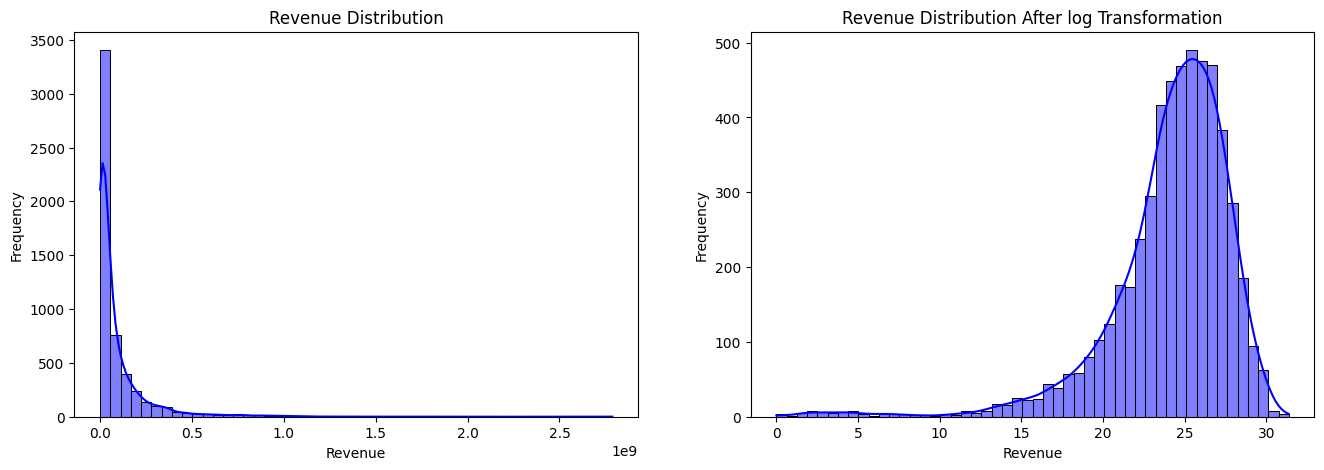

In [45]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
sns.histplot(dataset['revenue'],bins=50, kde=True, color='blue', ax=ax[0])
ax[0].set_title("Revenue Distribution")
ax[0].set_xlabel("Revenue")  
ax[0].set_ylabel("Frequency") 


transformed_revenue = np.log2(pd.to_numeric(dataset['revenue'], errors='coerce'))
sns.histplot(transformed_revenue,bins=50, kde=True, color='blue', ax=ax[1])
ax[1].set_title("Revenue Distribution After log Transformation")
ax[1].set_xlabel("Revenue")  
ax[1].set_ylabel("Frequency") 


let's look at the difference in errors and residuals between the model without and with the transformation.
we'll start by creating the data for the model. we make two copies of the `revenue` column: one with and one without the transformation.

In [46]:

X = dataset.drop(['revenue', 'original_title'], axis=1)
y = dataset['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train_transformed, y_test_transformed = np.log2(y_train) , np.log2(y_test)

categorical_features = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


This is the model we used in the last part.

In [47]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.2,
        max_depth=7,
        random_state=42
    ))
])

Let's fit the model on the two types of data:

In [48]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.fit(X_train, y_train_transformed)

y_pred_transformed = pipeline.predict(X_test)

Those are the results of the model without transformation. They are the same as in part 1 of the project.

In [49]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
residuals = y_test - y_pred
max_mistake = residuals.abs().max()
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Maximum Mistake: {max_mistake:.2f}")


Mean Absolute Error (MAE): 38267116.16
Mean Squared Error (MSE): 5406915153147464.00
Root Mean Squared Error (RMSE): 73531728.89
R-squared (R2): 0.82
Maximum Mistake: 816002192.00


Those are the results of the model with transformation. They are the same as in part 1 of the project.

In [50]:
mae_transformed = mean_absolute_error(y_test_transformed, y_pred_transformed)
mse_transformed = mean_squared_error(y_test_transformed, y_pred_transformed)
rmse_transformed = mse ** 0.5
r2_transformed = r2_score(y_test_transformed, y_pred_transformed)
residuals_transformed = y_test_transformed - y_pred_transformed
max_mistake_transformed = residuals_transformed.abs().max()
print(f"Mean Absolute Error (MAE): {mae_transformed:.2f}")
print(f"Mean Squared Error (MSE): {mse_transformed:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_transformed:.2f}")
print(f"R-squared (R2): {r2_transformed:.2f}")
print(f"Maximum Mistake: {max_mistake_transformed:.2f}")

Mean Absolute Error (MAE): 1.41
Mean Squared Error (MSE): 5.21
Root Mean Squared Error (RMSE): 73531728.89
R-squared (R2): 0.67
Maximum Mistake: 22.53


Text(0, 0.5, 'Residuals as % of True Values')

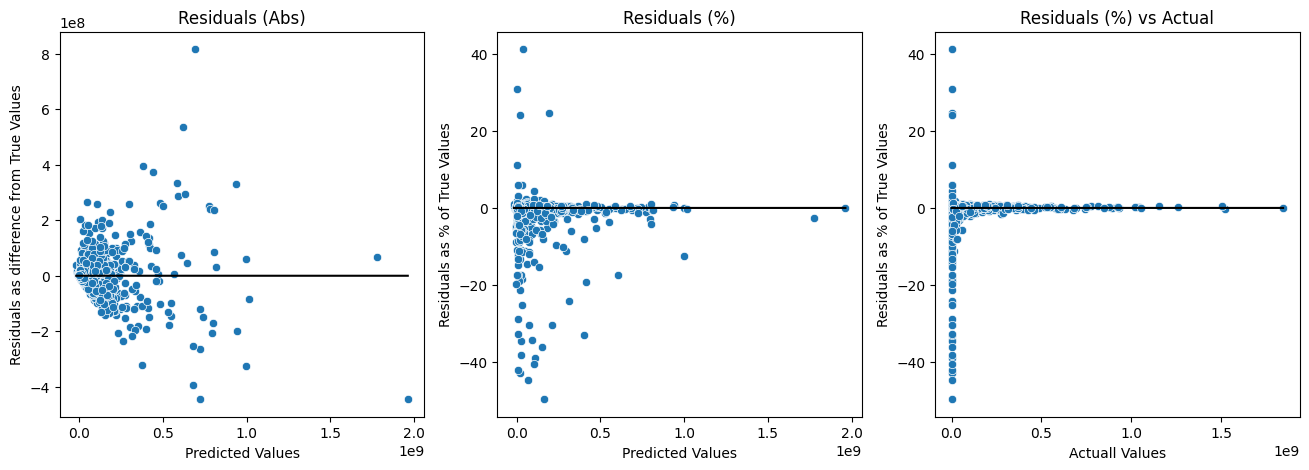

In [51]:


fig, ax = plt.subplots(1,3,figsize=(16,5))
sns.scatterplot(x= y_pred,y = residuals,ax=ax[0])
sns.lineplot(x= y_pred, y = 0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Values")  
ax[0].set_ylabel("Residuals as difference from True Values") 
filtered_residuals = residuals[(residuals / y_test).abs() < 50]
sns.scatterplot(x=y_pred, y=filtered_residuals / y_test, ax=ax[1])
sns.lineplot(x=y_pred, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Values")  
ax[1].set_ylabel("Residuals as % of True Values")  
sns.scatterplot(x=y_test, y=filtered_residuals / y_test, ax=ax[2])
sns.lineplot(x=y_test, y=0, ax=ax[2], color='black')
ax[2].set_title("Residuals (%) vs Actual")
ax[2].set_xlabel("Actuall Values")  
ax[2].set_ylabel("Residuals as % of True Values") 

# dataset['revenue'] = np.log2(pd.to_numeric(dataset['revenue'], errors='coerce'))



Text(0, 0.5, 'Residuals as % of True Values')

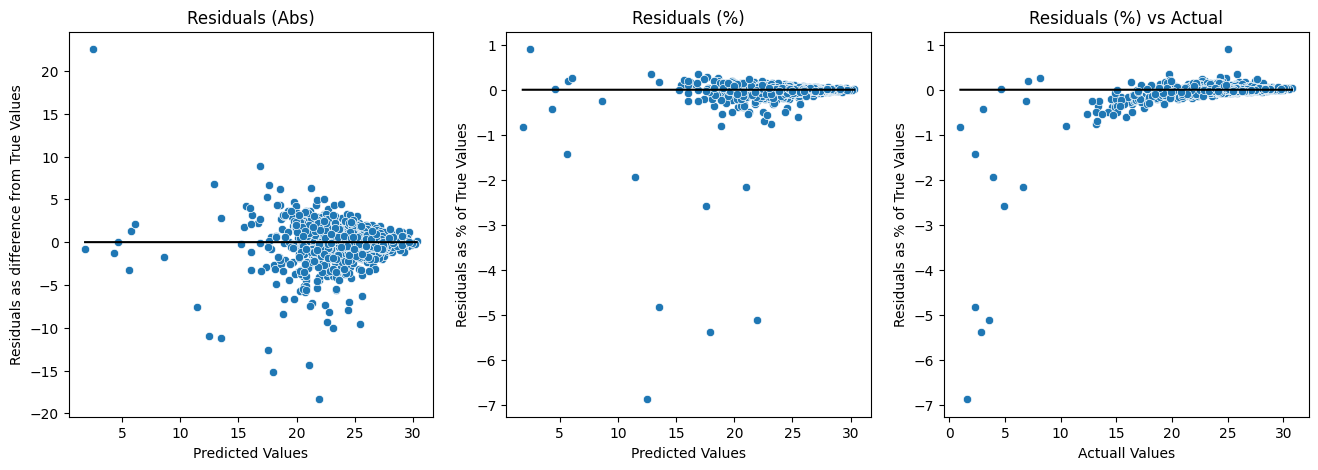

In [52]:
fig, ax = plt.subplots(1,3,figsize=(16,5))
sns.scatterplot(x= y_pred_transformed,y = residuals_transformed,ax=ax[0])
sns.lineplot(x= y_pred_transformed, y = 0,ax=ax[0],color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].set_xlabel("Predicted Values")  
ax[0].set_ylabel("Residuals as difference from True Values") 
filtered_residuals_transformed = residuals_transformed[(residuals_transformed / y_test_transformed).abs() < 50]
sns.scatterplot(x=y_pred_transformed, y=filtered_residuals_transformed / y_test_transformed, ax=ax[1])
sns.lineplot(x=y_pred_transformed, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].set_xlabel("Predicted Values")  
ax[1].set_ylabel("Residuals as % of True Values")  
sns.scatterplot(x=y_test_transformed, y=filtered_residuals_transformed / y_test_transformed, ax=ax[2])
sns.lineplot(x=y_test_transformed, y=0, ax=ax[2], color='black')
ax[2].set_title("Residuals (%) vs Actual")
ax[2].set_xlabel("Actuall Values")  
ax[2].set_ylabel("Residuals as % of True Values") 

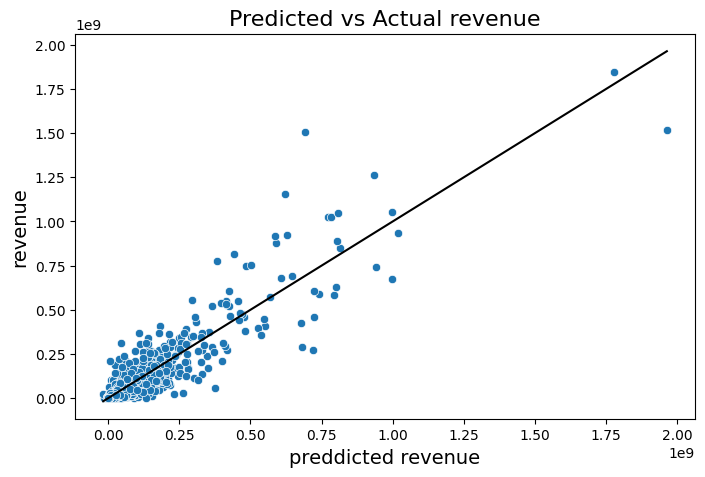

In [53]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x = y_pred,y = y_test, ax=ax)
sns.lineplot(x = y_pred,y = y_pred,ax=ax,color='black')
plt.title('Predicted vs Actual revenue', fontsize=16)
plt.xlabel('preddicted revenue', fontsize=14)
plt.ylabel('revenue',  fontsize=14)
plt.show()

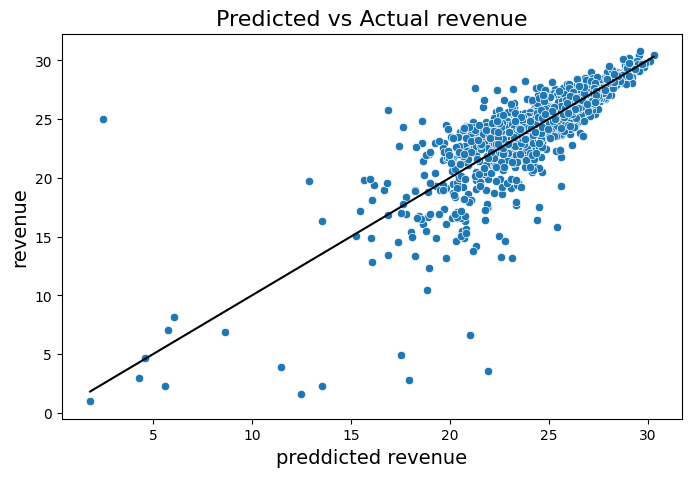

In [54]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x = y_pred_transformed,y = y_test_transformed, ax=ax)
sns.lineplot(x = y_pred_transformed,y = y_pred_transformed,ax=ax,color='black')
plt.title('Predicted vs Actual revenue', fontsize=16)
plt.xlabel('preddicted revenue', fontsize=14)
plt.ylabel('revenue',  fontsize=14)
plt.show()

- log on the revenue value to make it normal.
- dataset size is too small (5k instead of 50k).
- not using all of our features / using them partly.



Weaknesses:
- distribution of the data
- we were left with small dataset 
- there are not many movies with high revenue as compared to low revenue.
- because there are many low revenue movies that have not a lot of info they are harder to predict.
- using partial data.


- transaction algorithem - making the revenue into buckets and calculating the avrage bucket each cast member falls into. (Brad Pitt has many high revenue movies for example)


improvemenets:
-cast to revenue "grade"
-prod company to revenue "grade"
-normlize data
- maybe look at the time of year a movie is released in (maybe around the holidays movies earn more)
- consider using overvie
- use data that has budget 0 but revenue != 0 . we'll look at the revenue of all the movies with budget 0 and see how they look. maybe use LLM (chatGPT)